Part 2 

In [507]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt

In [509]:
def transpose(matrix):
    return [[matrix[j][i] for j in range(len(matrix))] for i in range(len(matrix[0]))]

def eye(n):
    return np.array([[float(1 if i == j else 0) for j in range(n)] for i in range(n)])

def zeros_vector(n):
    return np.array([0] * n)


# LCG 隨機數生成器
def lcg(modulus, a, c, seed, n):
    random_numbers = []
    for _ in range(n):
        seed = (a * seed + c) % modulus
        random_numbers.append(seed / modulus)
    return random_numbers

def random_uniform(low, high, size, seed=42):
    modulus = 2**32
    a = 1664525
    c = 1013904223
    random_numbers = lcg(modulus, a, c, seed, size)
    scaled_numbers = [low + (high - low) * rn for rn in random_numbers]
    return np.array(scaled_numbers)
    

# 用於生成A
def power_function(x, n): 
    return x ** n    
    
# 生成fit line fun.
def create_polynomial(n, coefficients):
    x = sp.symbols('x')
    polynomial = sum(coefficients[i] * x**i for i in range(n))
    return polynomial

def total_squared_error(n, coefficients):
    x = sp.symbols('x')
    polynomial = create_polynomial(n, coefficients)
    polynomial_func = sp.lambdify(x, polynomial, 'numpy')
    
    pred = polynomial_func(x_array)
    
    total_squared_error = sum((pred[i] - y_array[i]) ** 2 for i in range(len(pred)))
    return total_squared_error


# LU 分解
def lu_decomposition(A):
    n1 = A.shape[0]
    U = A.copy()
    L = eye(n1)
    
    for j in range(n1 - 1):
        if U[j, j] == 0:  
            non_zero_row = [i + (j+1) for i, val in enumerate(U[j+1:], start=j+1) if val[j] != 0]
            if len(non_zero_row) == 0:
                raise ValueError("矩陣不可逆，無法進行 LU 分解")
            U[[j, non_zero_row[0]], :] = U[[non_zero_row[0], j], :]
            L[[j, non_zero_row[0]], :j] = L[[non_zero_row[0], j], :j]
        
        for i in range(j + 1, n1):
            factor = U[i, j] / U[j, j]
            U[i, :] -= factor * U[j, :]
            L[i, j] = factor
    return L, U

def inverse(A):
    n1 = A.shape[0]
    L, U = lu_decomposition(A)
    I = eye(n1)
    for i in range(1, n1):
       for j in range(i):
           sum = L[i][j]
           for k in range(j+1, i):
               sum += L[i][k] * I[k][j]
           I[i][j] = -sum
    A_inv = [[0 for _ in range(n1)] for _ in range(n1)]
    for i in range(n1-1, -1, -1):
        for j in range(n1):
           sum = 0
           for k in range(i+1, n1):
               sum += U[i][k] * A_inv[k][j]
           A_inv[i][j] = (I[i][j] - sum) / U[i][i]
    return A_inv


In [511]:
def r_lse(c, A, b):
    A_t = np.transpose(A)
    A_t_A = np.dot(A_t, A)
    n1 = A_t_A.shape[0]

    inv = inverse(A_t_A + c * np.eye(n1))
    coefficients = np.dot(inv, np.dot(A_t, b))
    poly = create_polynomial(n1, coefficients)
    tse = total_squared_error(n1, coefficients)
    return poly, tse


In [513]:
def sign_vector(vector):
    return np.array([1 if v > 0 else -1 if v < 0 else 0 for v in vector])


def steepest_descent_method(c, A, b):
    A_t = transpose(A)
    A_t_A = np.dot(A_t, A)
    
    x0 = zeros_vector(n)
    
    learning_rate=0.001
    count = 0
    diff = 2 * np.dot(A_t_A, x0) - 2 * np.dot(A_t, b) + c * sign_vector(x0)
    s = 0
    for i in diff:
            s += i**2
    s = s ** (1/2)
    while (s > 1e-6):

        x1 = x0 - learning_rate * diff / s

        x0 = x1
        diff = 2 * np.dot(A_t_A, x0) - 2 * np.dot(A_t, b) + c * sign_vector(x0)
        s = 0
        for i in diff:
            s += i**2
        s = s ** (1/2)
        count += 1
        if count > 100000:
            break
    poly = create_polynomial(n, x0)
    tse = total_squared_error(n, x0)
    return poly, tse   

In [515]:
def Newton_Method(A, x_array, y_array):
    A_t = transpose(A)
    H = 2 * np.dot(A_t, A)
    
    x0 = random_uniform(-5, 5, n)

    dx = 100
    
    count = 0
    while (dx > 1e-6):
        x1 = x0 - np.dot(inverse(H),  np.dot(H, x0) - 2 * np.dot(A_t, y_array))
        d = 0
        for i in range(n):
            if x1[i] - x0[i] < 0:
                d += -(x1[i] - x0[i])
            else:
                d += x1[i] - x0[i]
        if (d <= dx):
            dx = d
            x0 = x1
        else:
            break
        count += 1
        if count > 1000:
            break
    poly = create_polynomial(n, x0)
    tse = total_squared_error(n, x0)
    return poly, tse


In [517]:
def polynomial_to_function(poly):
    x = sp.symbols('x')
    poly = sp.sympify(poly)
    f = sp.lambdify(x, poly, 'numpy')
    return f

def plot_polynomials(ploy, titles, x_array, y_array, x_range=(-6, 6), num_points=500):
    x_vals = np.linspace(x_range[0], x_range[1], num_points)
    
    plt.figure(figsize=(10, 15))  
    
    for i, (expr_str, title) in enumerate(zip(ploy, titles)):
        poly_func = polynomial_to_function(expr_str)
        y_vals = poly_func(x_vals)
        
        plt.subplot(len(ploy), 1, i + 1)  
        plt.plot(x_vals, y_vals, label="fitting line")
        plt.scatter(x_array, y_array, color='red', marker='o', label='Data Points')  # 添加散点图
        plt.title(title) 
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)
        plt.legend()
    
    plt.tight_layout()  
    plt.show()

In [519]:
def show_all():
    poly_1, tse_1 = r_lse(c, A, y_array)
    poly_2, tse_2 = steepest_descent_method(c, A, y_array)
    poly_3, tse_3 = Newton_Method(A, x_array, y_array)

    print("LSE: ")  
    print("Fitting line:", poly_1)
    print("Total error: ", tse_1)
    print("Steepest Gradient Method: ")  
    print("Fitting line:", poly_2)
    print("Total error: ", tse_2)
    print("Newton's Method: ")  
    print("Fitting line:", poly_3)
    print("Total error: ", tse_3)
    

    plot_polynomials(
        [poly_1, poly_2, poly_3], 
        ['LSE', 'Steepest Gradient Method', "Newton's Method"],  
        x_array,
        y_array)

    plt.figure(figsize=(10, 5))
    plt.text(0.1, 0.8, "LSE:", fontsize=12, weight='bold')
    plt.text(0.1, 0.6, f"Fitting line: {poly_1}", fontsize=10)
    plt.text(0.1, 0.4, f"Total error: {tse_1}", fontsize=10)
    plt.text(0.1, 0.2, "Steepest Gradient Method:", fontsize=12, weight='bold')
    plt.text(0.1, 0.0, f"Fitting line: {poly_2}", fontsize=10)
    plt.text(0.1, -0.2, f"Total error: {tse_2}", fontsize=10)
    plt.text(0.1, -0.4, "Newton's Method:", fontsize=12, weight='bold')
    plt.text(0.1, -0.6, f"Fitting line: {poly_3}", fontsize=10)
    plt.text(0.1, -0.8, f"Total error: {tse_3}", fontsize=10)
    
    plt.axis('off')  
    plt.tight_layout()
    plt.show()

In [521]:
with open("test.txt") as file:
    data = file.read()

lines = data.splitlines()

x_values = []
y_values = []


for line in lines:

    coords = line.split(',')
    if len(coords) == 2:
        try:
            x = float(coords[0])
            y = float(coords[1])
            x_values.append(x)
            y_values.append(y)
        except ValueError:

            print(f"讀取錯誤: {line}")


x_array = np.array(x_values)
y_array = np.array(y_values)


The number of polynomial bases n:  2
lambda:  0


LSE: 
Fitting line: 4.43295031007681*x + 29.3064047060563
Total error:  16335.123164957968
Steepest Gradient Method: 
Fitting line: 4.43322029843605*x + 29.3063999394637
Total error:  16335.123181385461
Newton's Method: 
Fitting line: 4.43295031007681*x + 29.3064047060563
Total error:  16335.123164957968


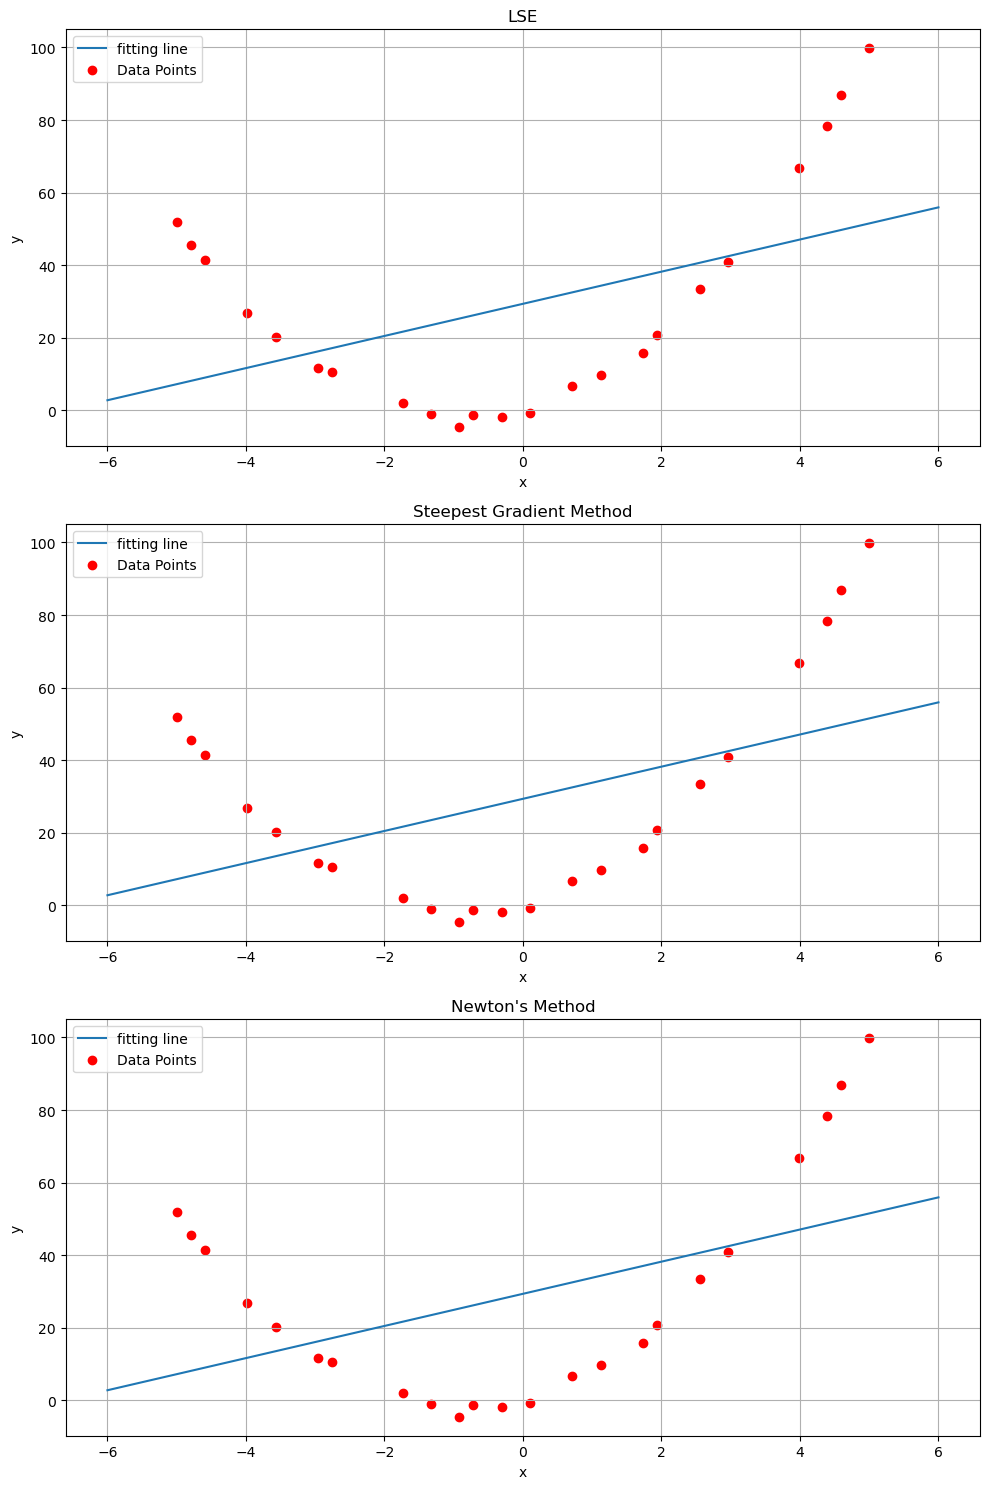

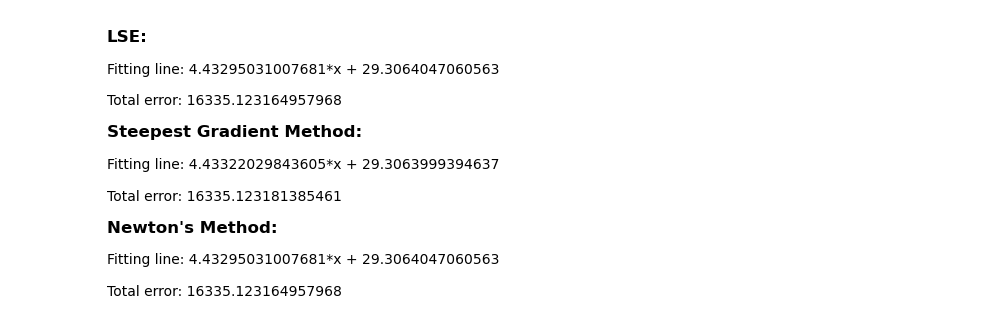

In [523]:
results = []
n = int(input("The number of polynomial bases n: "))
c = float(input("lambda: "))
for i in range(n): 
    results.append(power_function(x_array, i))

A = np.column_stack(results)

show_all()

The number of polynomial bases n:  3
lambda:  0


LSE: 
Fitting line: 3.02385339348657*x**2 + 4.9061902638638*x - 0.231401756087713
Total error:  26.559959499333015
Steepest Gradient Method: 
Fitting line: 3.02435251062931*x**2 + 4.90618098491203*x - 0.231373542989824
Total error:  26.56096167331699
Newton's Method: 
Fitting line: 3.02385339348657*x**2 + 4.9061902638638*x - 0.231401756087723
Total error:  26.559959499333


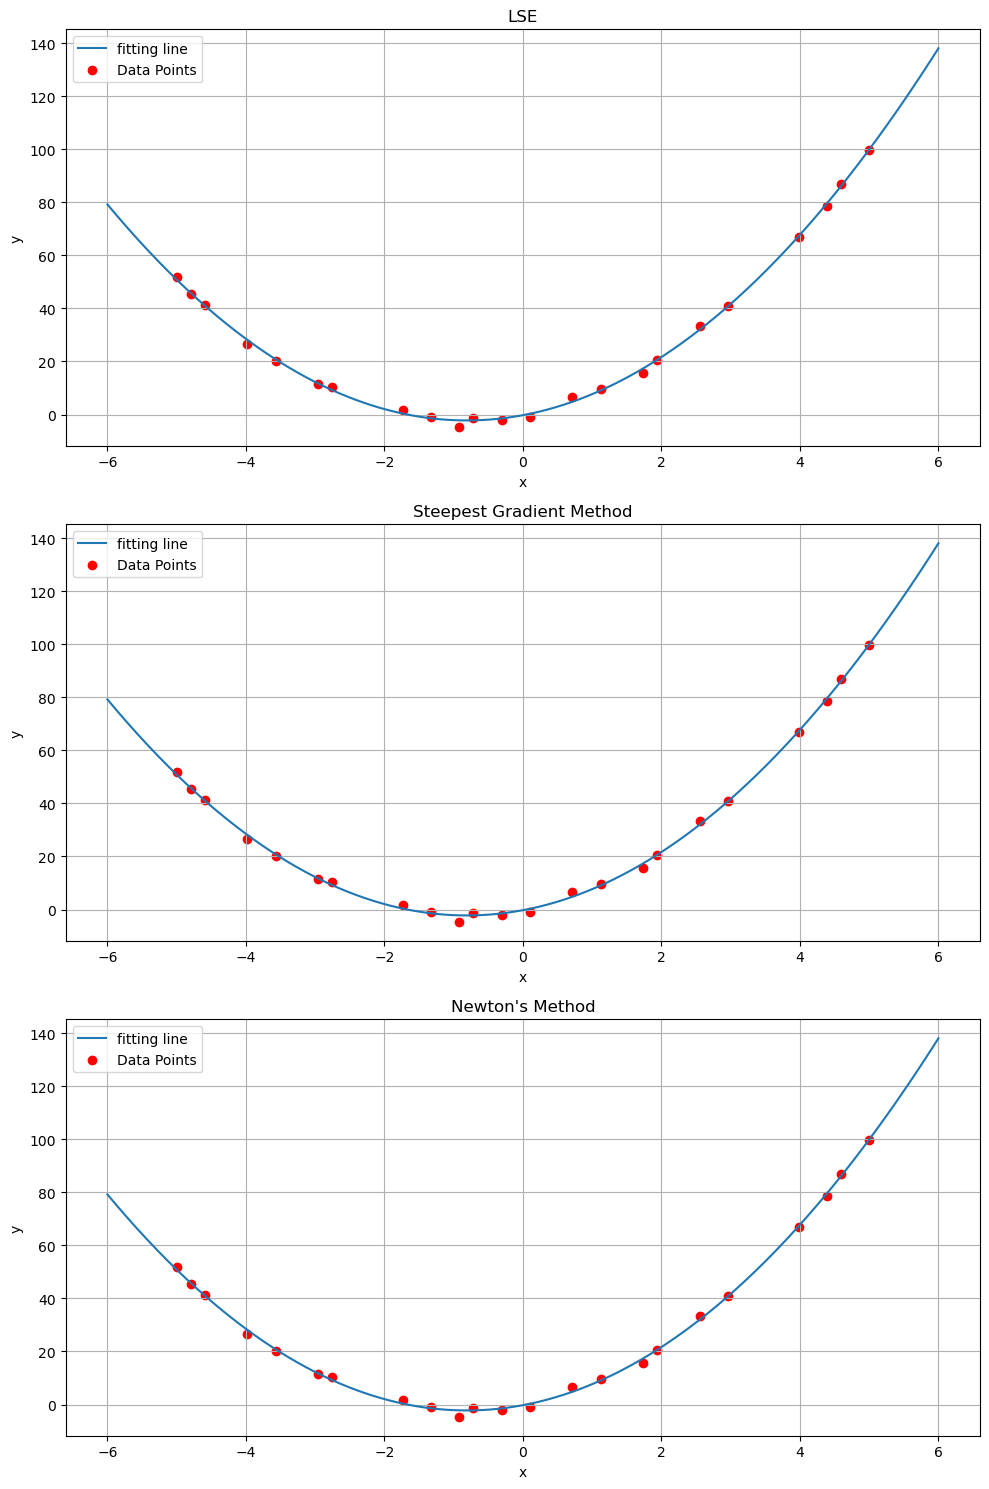

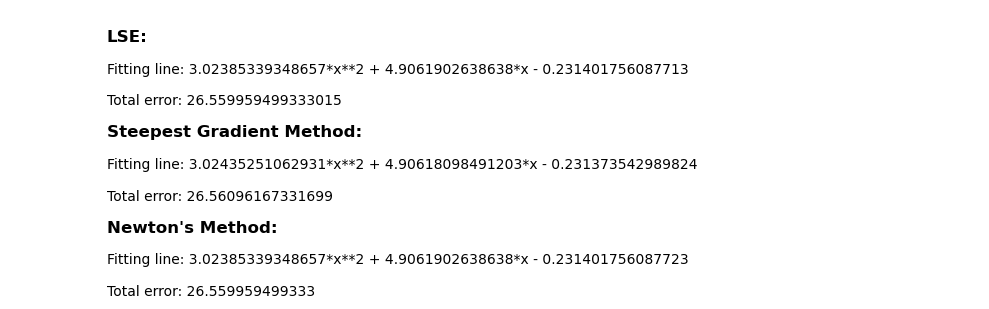

In [525]:
results = []
n = int(input("The number of polynomial bases n: "))
c = float(input("lambda: "))
for i in range(n): 
    results.append(power_function(x_array, i))
    
A = np.column_stack(results)

show_all()

The number of polynomial bases n:  3
lambda:  10000


LSE: 
Fitting line: 0.834533282700286*x**2 + 0.0931481983191882*x + 0.0469506992734693
Total error:  22649.738493024146
Steepest Gradient Method: 
Fitting line: 1.6729961829101*x**2 + 0.000609442463772003*x + 0.000218192384819242
Total error:  11675.021191730313
Newton's Method: 
Fitting line: 3.02385339348657*x**2 + 4.9061902638638*x - 0.231401756087723
Total error:  26.559959499333


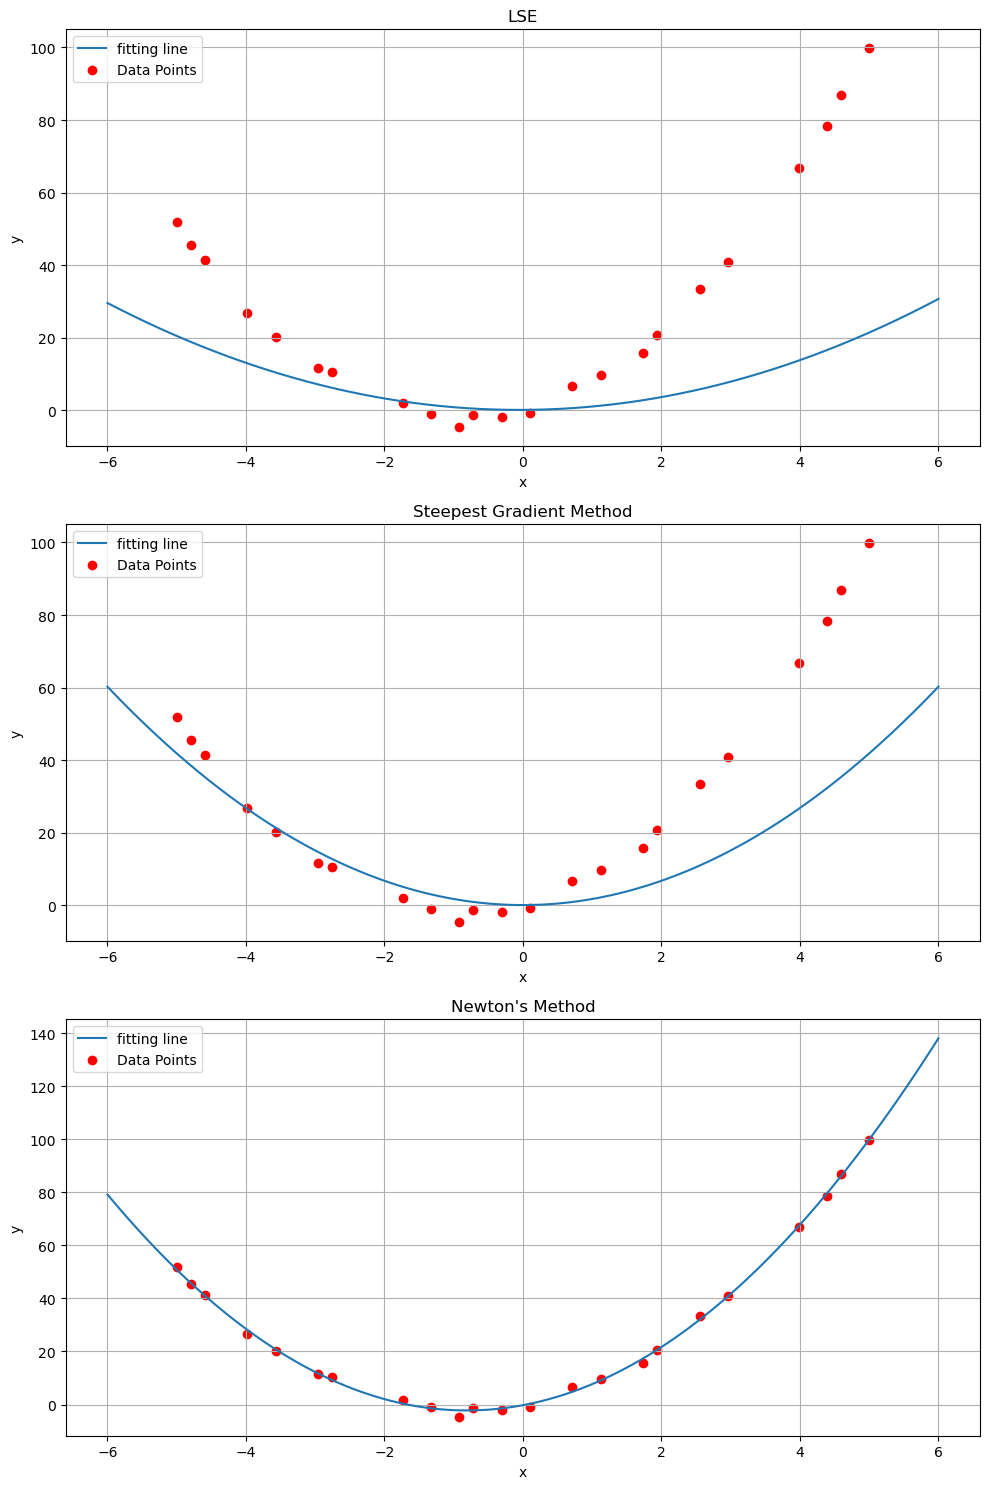

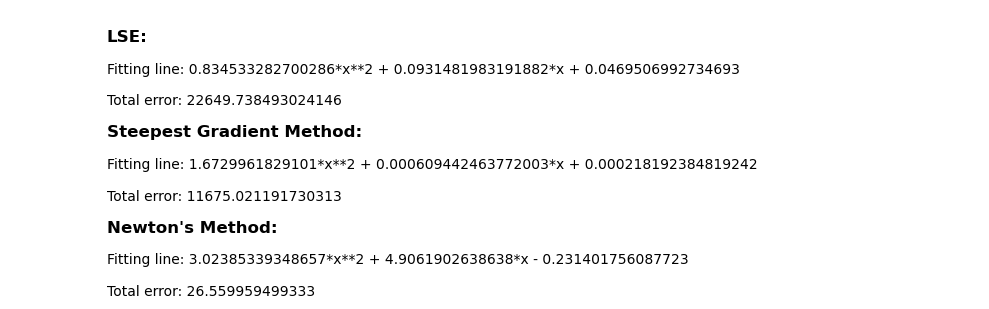

In [527]:
results = []
n = int(input("The number of polynomial bases n: "))
c = float(input("lambda: "))
for i in range(n): 
    results.append(power_function(x_array, i))

A = np.column_stack(results)

show_all()